In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyerrors as pe

In [2]:
plt.style.use('./base_style.mplstyle')
plt.rc('text', usetex=True)

## Primary observables

We can load data from preprocessed files which contains lists of `pyerror` `Obs` and convert them to `Corr` objects. We use the parameters `padding_front` and `padding_back` to keep track of the fixed boundary conditions at both temporal ends of the lattice.

In [3]:
p_obs_names = [r'f_A', r'f_P']

p_obs = {}
for i, item in enumerate(p_obs_names):
    tmp_data = pe.input.json.load_json("./data/" + item)
    p_obs[item] = pe.Corr(tmp_data, padding_front=1, padding_back=1)
    p_obs[item].tag = item

Data has been written using pyerrors 2.0.0.
Format version 0.1
Written by fjosw on 2022-01-06 11:27:27 +0100 on host XPS139305, Linux-5.11.0-44-generic-x86_64-with-glibc2.29

Description:  SF correlation function f_A on a test ensemble
Data has been written using pyerrors 2.0.0.
Format version 0.1
Written by fjosw on 2022-01-06 11:27:34 +0100 on host XPS139305, Linux-5.11.0-44-generic-x86_64-with-glibc2.29

Description:  SF correlation function f_P on a test ensemble


We can now use the method `Corr.show` to have a quick look at the data we just read in 

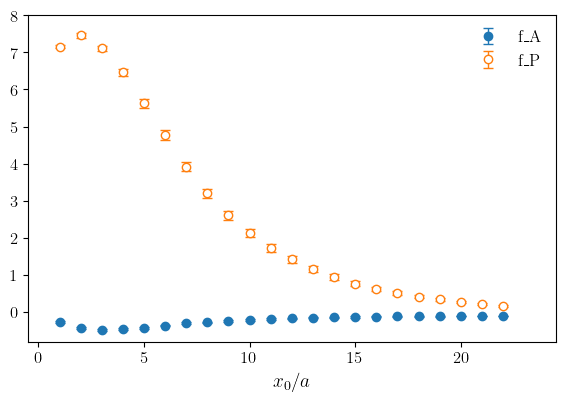

In [4]:
p_obs['f_A'].show(comp=p_obs['f_P'], y_range=[-0.8, 8])

## Constructing the PCAC mass

For the PCAC mass we now need to obtain the first derivative of f_A and the second derivative of f_P

In [5]:
first_deriv_fA = p_obs['f_A'].deriv()
first_deriv_fA.tag = r"First derivative of f_A"

In [6]:
second_deriv_fP = p_obs['f_P'].second_deriv()
second_deriv_fP.tag = r"Second derivative of f_P"

We can use these to obtain the unimproved PCAC mass:

In [7]:
am_pcac = first_deriv_fA / 2 / p_obs['f_P']
am_pcac.tag = "Unimproved PCAC mass"

And with the inclusion of the improvement coefficient $c_\mathrm{A}$ also the $\mathrm{O}(a)$ improved PCAC mass:

In [8]:
cA = -0.03888694628624465
am_pcac_impr = (first_deriv_fA + cA * second_deriv_fP) / 2 / p_obs['f_P']
am_pcac_impr.tag = "Improved PCAC mass"

We can take a look at the time dependence of the PCAC mass with the method `Corr.show`:

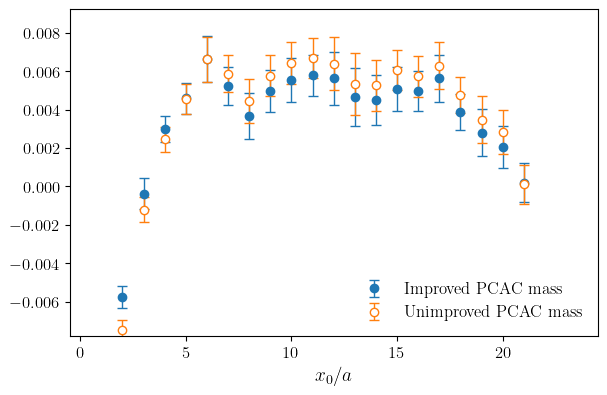

In [9]:
am_pcac_impr.show(comp=am_pcac)

## Plateau values

We can now construct a plateau as a derived observable from the masses.

In [17]:
pcac_plateau = am_pcac_impr.plateau([7, 16])  # We manually specify the plateau range here
pcac_plateau.gamma_method()
pcac_plateau.details()

Fit with 1 parameters
Method: Levenberg-Marquardt
`ftol` termination condition is satisfied.
chisquare/d.o.f.: 0.2704765091136813
Result	 5.03431904e-03 +/- 5.38835422e-04 +/- 8.24919899e-05 (10.703%)
 t_int	 5.15384615e-01 +/- 1.25000000e-01 S = 3.00
64 samples in 1 ensemble:
  · Ensemble 'test_ensemble' : 64 configurations (from 1 to 64)


We can now plot the data with the two plateaus

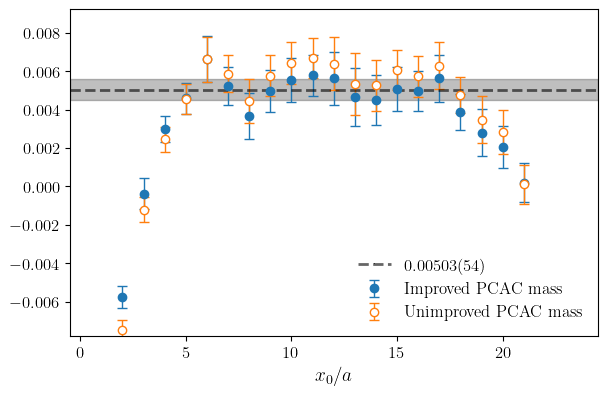

In [11]:
am_pcac_impr.show(comp=am_pcac, plateau=pcac_plateau)

## Refined error analysis

There are two way of adjusting the value of S. One can either change the class variable `Obs.S_global`. The set value is then used for all following applications of the `gamma_method`.

In [12]:
pe.Obs.S_global = 3.0
pcac_plateau.gamma_method()
pcac_plateau.details()

Result	 5.03431904e-03 +/- 5.38835422e-04 +/- 8.24919899e-05 (10.703%)
 t_int	 5.15384615e-01 +/- 1.25000000e-01 S = 3.00
64 samples in 1 ensemble:
  · Ensemble 'test_ensemble' : 64 configurations (from 1 to 64)


Alternatively one can call the gamma_method with the keyword argument S. This value overwrites the global value only for the current application of the `gamma_method`.

In [13]:
pcac_plateau.gamma_method(S=2.5)
pcac_plateau.details()

Result	 5.03431904e-03 +/- 5.38835422e-04 +/- 8.24919899e-05 (10.703%)
 t_int	 5.15384615e-01 +/- 1.25000000e-01 S = 2.50
64 samples in 1 ensemble:
  · Ensemble 'test_ensemble' : 64 configurations (from 1 to 64)


`pyerrors` also supports the critical slowing down analysis of arXiv:1009.5228

In [14]:
pcac_plateau.gamma_method(tau_exp=10)
pcac_plateau.details()

Result	 5.03431904e-03 +/- 7.82447810e-04 +/- 1.19787368e-04 (15.542%)
 t_int	 1.08675071e+00 +/- 1.63643098e+00 tau_exp = 10.00,  N_sigma = 1
64 samples in 1 ensemble:
  · Ensemble 'test_ensemble' : 64 configurations (from 1 to 64)


The Monte Carlo history of the observable can be accessed with `plot_history` to identify possible outliers or have a look at the shape of the distribution

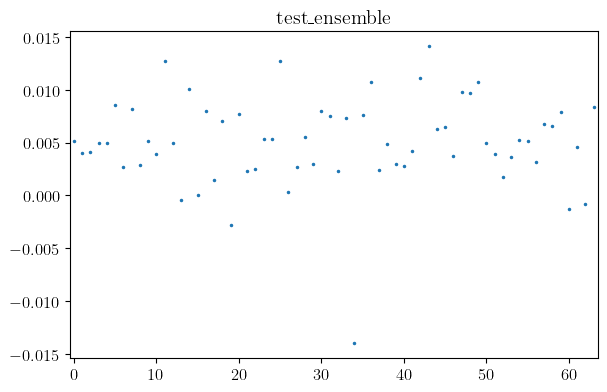

In [15]:
pcac_plateau.plot_history()

If everything is satisfactory, dump the `Obs` in a pickle file for future use. The `Obs` `pcac_plateau` conatains all relevant information for any follow up analyses.

In [16]:
pe.input.json.dump_to_json(pcac_plateau, "pcac_plateau_test_ensemble")